 # Feature Extraction

This chapter is a deep-dive on the most frequently used dimensionality reduction algorithm, Principal Component Analysis (PCA). You'll build intuition on how and why this algorithm is so powerful and will apply it both for data exploration and data pre-processing in a modeling pipeline. You'll end with a cool image compression use case.

## Feature extraction

Feature extraction is essentially the calculating of new features based on the existing ones while trying to lose as little information as possible. 

### Feature selection vs extraction

Feature extraction is different in the sense that it creates new features, which are in fact combinations of the original ones.

![alt text](images/feature_selection_vs_extraction.png)

There are powerful algorithms that will calculate the new features in a way that as much information as possible is preserved, but before we get into those, let's look at more simple feature extraction.

### Feature generation - BMI

Take for example the body mass index or BMI we've worked with before. Its a measure on whether a person is under- or overweight regardless of their height; and can be calculated by dividing a person's weight by the square of the height. 

```python
df_body['BMI'] = df_body['Weight kg'] / df_body['Height m'] ** 2
```

If we build a diabetes model on this data the height and weight features by themselves might be obsolete once we have the BMI and could be dropped to reduce dimensionality. 

### Feature generation - averages

Imagine that our body measurement dataset would have measurements of both left and right leg lengths. For most applications it would be sufficient to reduce these two features into a single leg length feature, then drop them.

```python
df_body['leg length mm'] = df_body[['right leg mm', 'left leg mm']].mean(axis=1)
df_body.drop(['right leg mm', 'left leg mm'], axis=1)
```

### Cost of taking the average

Taking the average comes at the expense of losing some information (in this case, the cost is small).

Zooming in we can see the differences between both features more clearly. 

![alt text](images/cost_of_taking_average.png)

When we add a line for where the two features are equal it becomes easy to identify people with different leg lengths. 

![alt text](images/cost_of_taking_average_add_line.png)

The cost of taking the average is that you lose the information about people whose leg lengths are different.

### Intro to PCA

Now let's take a step back and look at a different data sample with hand lengths versus feet lengths. Instead of taking the mean of both features we'll explore an alternative technique. 

```python
sns.scatterplot(data=df, x='handlength', y='footlength')
```

![alt text](images/hand_vs_foot_length.png)

When using PCA it's important to scale the features first, so that their values are easier to compare.

```python
scaler = StandardScaler()
df_std = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
```

![alt text](images/hand_vs_foot_length_scaled.png)

The strongest pattern in this dataset is that people with big feet tend to have big hands.

We can add a reference point to the center of the point cloud and then point a vector in the direction of this strongest pattern. People with a positive value for this vector have relatively long hands and feet, and people with a negative value have relatively short ones. 

![alt text](images/hand_vs_foot_length_vector.png)

We could add a second vector perpendicular to the first one to account for the rest of the variance in this dataset. People with a positive value for this second vector have relatively long feet compared to their hand length and people with a negative value have relatively big hands. 

![alt text](images/hand_vs_foot_length_vector_2.png)

Every point in this dataset could be described by multiplying and then summing these two perpendicular vectors.

We've essentially created a new reference system aligned with the variance in the data. The coordinates that each point has in this new reference system are called principal components, and they are the foundation of principal component analysis or PCA which is the main topic of this chapter. 

#### Manual feature extraction I

You want to compare prices for specific products between stores. The features in the pre-loaded dataset `sales_df` are: `storeID`, `product`, `quantity` and `revenue`. The `quantity` and `revenue` features tell you how many items of a particular product were sold in a store and what the total revenue was. For the purpose of your analysis it's more interesting to know the average price per product.

##### Instructions

* Calculate the product price from the quantity sold and total revenue.
* Drop the quantity and revenue features from the dataset.

In [2]:
# setup
import pandas as pd

sales_df = pd.read_csv("data/sales.csv")

/tmp/ipykernel_2300/1362121465.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Calculate the price from the quantity sold and revenue
sales_df["price"] = sales_df["revenue"] / sales_df["quantity"]

# Drop the quantity and revenue features
reduced_df = sales_df.drop(["revenue", "quantity"], axis=1)

print(reduced_df.head())

  storeID  product     price
0       A   Apples  5.135616
1       A  Bananas  3.365105
2       A  Oranges  5.317020
3       B   Apples  5.143417
4       B  Bananas  3.898517


#### Manual feature extraction II

You're working on a variant of the ANSUR dataset, `height_df`, where a person's height was measured 3 times: `height_1`, `height_2`, `height_3`. Add a feature with the mean height to the dataset, then drop the 3 original features.

##### Instructions

* Add a feature with the mean height to the dataset. Use the `.mean()` method with `axis=1`.
* Drop the 3 original height features from the dataset.

In [4]:
# setup
import pandas as pd

height_df = pd.read_csv("data/ansur_manual_feature_extraction.csv")

In [5]:
height_df["height"] = height_df[["height_1", "height_2", "height_3"]].mean(axis=1)
reduced_df = height_df.drop(["height_1", "height_2", "height_3"], axis=1)

print(reduced_df.head())

   weight_kg    height
0       81.5  1.793333
1       72.6  1.696667
2       92.9  1.740000
3       79.4  1.670000
4       94.6  1.913333


#### Principal component intuition

![alt text](images/principal_component_intuition.png)

After standardizing the lower and upper arm lengths from the ANSUR dataset we've added two perpendicular vectors that are aligned with the main directions of variance. We can describe each point in the dataset as a combination of these two vectors multiplied with a value each. These values are then called principal components.

Which of the following statements is true?

**Possible Answers**

1. People with a negative component for the yellow vector have long forearms relative to their upper arms.
2. People with a positive component for the yellow vector have long forearms relative to their upper arms.
3. People with a negative component for the red vector have above average arm lengths.
4. People with a positive component for the red vector have below average arm lengths.

**Answer**

1. People with a negative component for the yellow vector have long forearms relative to their upper arms.

## Principal component analysis

Let's take a deeper look into principal component analysis. 

### PCA concept

We already saw that you can describe the information captured by two features by using two perpendicular vectors that are aligned with the variance in the data. 

For instance the point highlighted here has coordinates 2.7 and 1 in the original hand length versus foot length reference system. 

![alt text](images/pca_concept_point.png)

But we could just as well describe this point using multiplications of the vectors. In this case it would be 2 times the red vector and minus 1 times the yellow vector. 

![alt text](images/pca_concept_vector.png)

We call these values the first and second principal components respectively, where the red one is most important as it is aligned with the biggest source of variance in the data. We can calculate these principal components for all points in the dataset with sklearn's `PCA()` class.

### Calculating the principal components

Before we do this, we have to scale the values with the `StandardScaler()`. PCA can really underperform if you don't do this.

We can then create our PCA instance and apply the `.fit_transform()` method to the scaled data to calculate the two principal components. 

```python
from sklearn.preprocessing import Standard Scalar

scaler = StandardScaler()
std_df = scaler.fit_transform(df)

from sklearn.decomposition import PCA

pca = PCA()
print(pca.fit_transform(std_df))
```

```sh
[[-0.08320426 -0.12242952]
 [ 0.31460044  0.57048158]
 ...
 [-0.56095233  0.31713944]
 [-0.04483043 -0.34835231]]
```

### PCA removes correlation

When we plot these values for all points in the dataset, you'll see that our resulting point cloud no longer shows any correlation and therefore, no more duplicate information

![alt text](images/pca_removes_correlation.png)

 If we would add a third feature to the original dataset we would also have to add a third principal component if we don't want to lose any information. And this remains true as you keep adding features. You could describe a 100 feature dataset with 100 principal components. But why would you want to do such a thing? The components are much harder to understand than the original features. 

### Principal component explained variance ratio

The answer lies in the fact that the components share no duplicate information and that they are ranked from most to least important.

We can access the explained variance ratio of each principal component after fitting the algorithm to the data using the `.explained_variance_ratio_` attribute.

```python
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(std_df)
print(pca.explained_variance_ratio_)
```

```sh
array([0.90, 0.10])
```

In this case it tells us that the first components explains 90% of the variance in the data and the second the remaining 10%.

When you are dealing with a dataset with a lot of correlation the explained variance typically becomes concentrated in the first few components. The remaining components then explain so little variance that they can be dropped. This is why PCA is so powerful for dimensionality reduction. 

### PCA for dimensionality reduction

Let's look at a data sample with very strong correlation. The right versus left leg length data we already saw last lesson. 

![alt text](images/pca_for_dimensionality_reduction.png)

The first component here explains more than 99.9% of the variance in the data and therefore it would clearly make sense to drop the second component.

Two-feature datasets make it easier to see what PCA is doing behind the scenes but they are way too small for an actual dimensionality reduction use case. So let's look at a more high dimensional example.

![alt text](images/pca_for_dimensionality_reduction_2.png)

The full ANSUR dataset has 94 highly correlated features. When we fit pca to this data we'll find that the 2 first components explain 44 and 18% of the variance in the data. 

We can use NumPy's cumulative sum (`cumsum()`) method on the `.explained_variance_ratio_` attribute to see how much variance we can explain in total by using a certain number of components.

![alt text](images/pca_for_dimensionality_reduction_3.png)

Using just the first two components would still allow us to keep 62% of the variance in the data whereas we would have to use 10 components if we would want to keep 80% of the variance. 

#### Calculating Principal Components

You'll visually inspect a 4 feature sample of the ANSUR dataset before and after PCA using Seaborn's `pairplot()`. This will allow you to inspect the pairwise correlations between the features.

The data has been pre-loaded for you as `ansur_df`.

##### Instructions 1/4

* Create a Seaborn pairplot to inspect `ansur_df`.


In [6]:
# setup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

ansur_df = pd.read_csv("data/ansur_pca.csv")

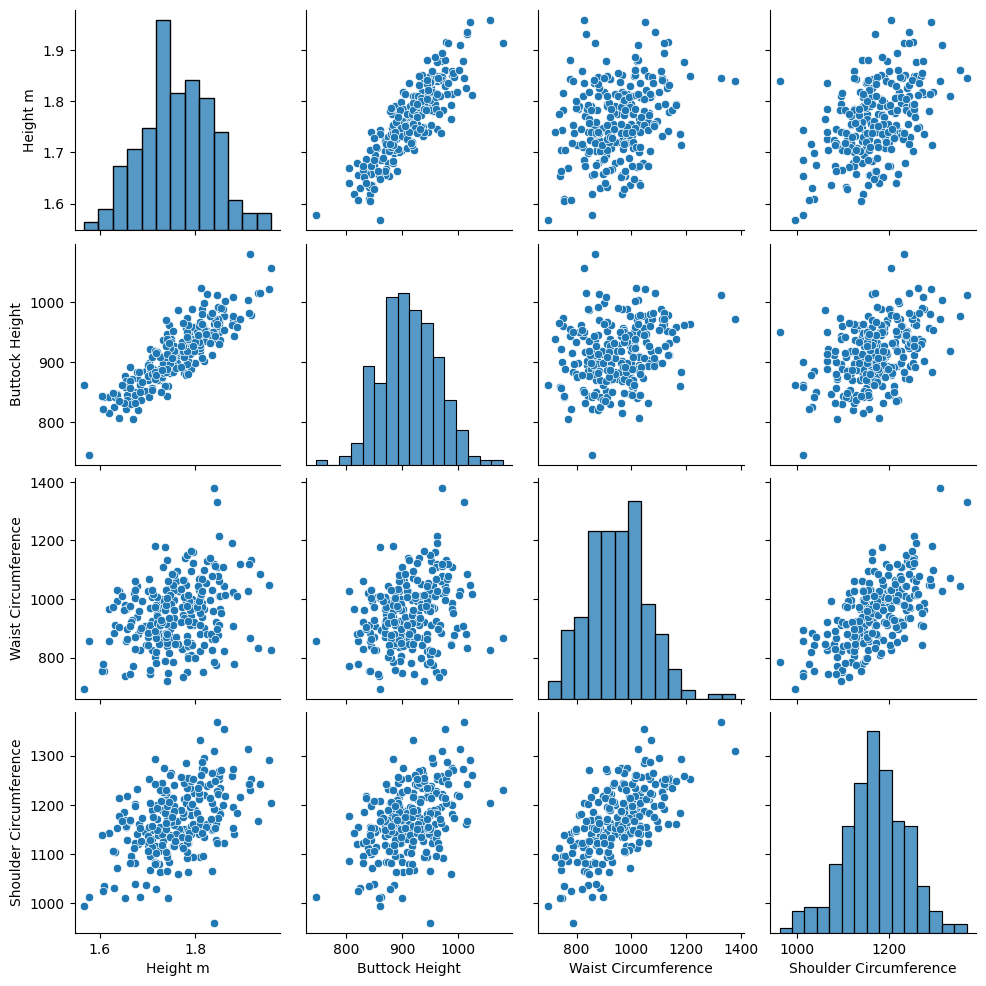

In [7]:
sns.pairplot(ansur_df)
plt.show()

##### Instructions 2/4

* Create the scaler and standardize the data.

In [8]:
scaler = StandardScaler()
ansur_std = scaler.fit_transform(ansur_df)

##### Instructions 3/4

* Create the `PCA()` instance and fit and transform the standardized data.

In [9]:
# create the PCA instance and fit and transform the data with pca
pca = PCA()
pc = pca.fit_transform(ansur_std)

# change the numpy array output back to a DataFrame
pc_df = pd.DataFrame(pc, columns=["PC 1", "PC 2", "PC 3", "PC 4"])

##### Instructions 4/4

* Create a pairplot of the principal component DataFrame.

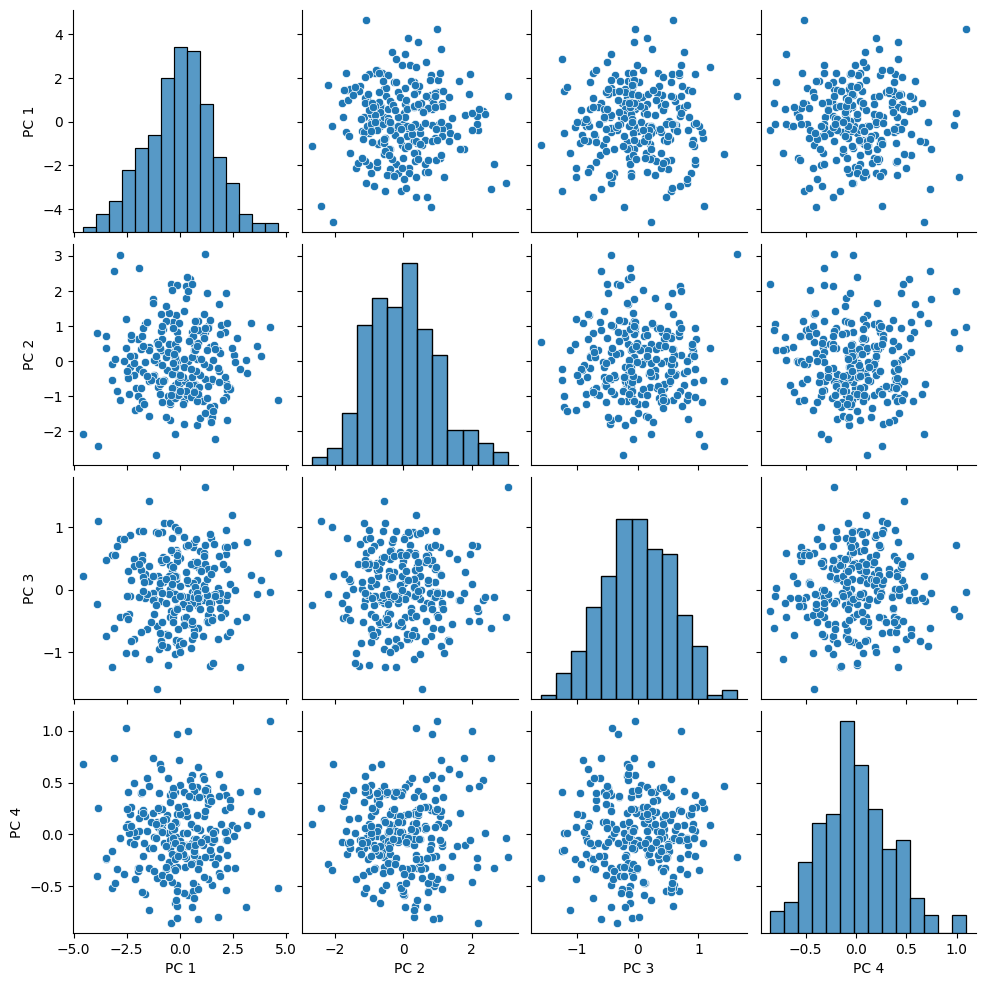

In [10]:
sns.pairplot(pc_df)
plt.show()

#### PCA on a larger dataset

You'll now apply PCA on a somewhat larger ANSUR datasample with 13 dimensions, once again pre-loaded as `ansur_df`. The fitted model will be used in the next exercise. Since we are not using the principal components themselves there is no need to transform the data, instead, it is sufficient to fit pca to the data.

##### Instructions

* Create the `scaler`.
* Standardize the data.
* Create the `PCA()` instance.
* Fit it to the standardized data.

In [11]:
# setup
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

ansur_df = pd.read_csv("data/ansur_larger_dataset.csv")

In [12]:
scaler = StandardScaler()
ansur_std = scaler.fit_transform(ansur_df)
pca = PCA()
pca.fit(ansur_std)

PCA()

#### PCA explained variance

You'll be inspecting the variance explained by the different principal components of the `pca` instance you created in the previous exercise.

##### Instructions 1/4

* Print the explained variance ratio per principal component.

In [13]:
print(pca.explained_variance_ratio_)

[0.61449404 0.19893965 0.06803095 0.03770499 0.03031502 0.0171759
 0.01072762 0.00656681 0.00634743 0.00436015 0.0026586  0.00202617
 0.00065268]


##### Instructions 2/4

**Question**

How much of the variance is explained by the 4th principal component?

**Possible answers**

1. About 3.03%
2. About 3.77%
3. About 6.8%
4. About 61.45%

**Answer**

2. About 3.77%

##### Instructions 3/4

* Calculate the cumulative sum of the explained variance ratio using a method of `pca.explained_variance_ratio_`.

In [14]:
import numpy as np

np.cumsum(pca.explained_variance_ratio_)

array([0.61449404, 0.81343368, 0.88146463, 0.91916962, 0.94948464,
       0.96666054, 0.97738816, 0.98395496, 0.99030239, 0.99466254,
       0.99732115, 0.99934732, 1.        ])

##### Instructions 4/4

**Question**

What's the lowest number of principal components you should keep if you don't want to lose more than 10% of explained variance during dimensionality reduction?

**Possible answers**

1. 2 principal components
2. 3 principal components
3. 4 principal components
4. 5 principal components

**Answer**

3. 4 principal components

## PCA Applications

When you use PCA for dimensionality reduction you decide how much of the explained variance you're willing to sacrifice.

However, one downside of PCA is that the remaining components can be hard to interpret. 

### Understanding the components

To improve your understanding of the components it can help to look at the `components_` attribute. 

It tells us to what extent each component's vector is affected by a particular feature.

The features with the biggest positive or negative effects on a component can then be used to add a meaning to that component.

![alt text](images/components_attribute.png)

In the example shown here the effects of the features on the first components are positive and equally strong at 0.71. So the first component is affected just as much by hand as foot length. However, the second component is negatively affected by hand length. So people who score high for the second component have short hands compared to their feet. 

When we apply this technique to the combined male-female ANSUR dataset we find that the first component is mostly affected by overall body height. To verify this I've added body height categories to the data. When we plot the first two components and color the points with these categories, we can see that they pretty much align with the X-axis or first principal component. We therefore learn that the most important source of variance in this dataset, has something to do with how tall a person is. 

![alt text](images/pca_for_data_exploration.png)

### PCA in a pipeline

Let's look at the code for creating this plot.

Since we always scale the data before applying PCA we can combine both operations in a *pipeline*. We pass the two operations to the `Pipeline()` class in the form of two tuples inside a list. Within each tuple we give our operation a name, `'scaler'` and `'reducer'` in this example, and then fit and transform the data in one go. 

```python
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reducer', PCA())
])

pc = pipe.fit_transform(ansur_df)

print(pc[:, :2])
```

In [15]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

ansur_df = pd.read_csv("data/ansur_all.csv")
numeric_columns = ansur_df.select_dtypes(include=["int64", "float64"]).columns

# pipe = Pipeline(
#     [
#         (
#             "preprocessor",
#             ColumnTransformer(transformers=[("scalar", StandardScaler(), numeric_columns)], remainder="passthrough"),
#         ),
#         # ("scaler", StandardScaler()),
#         ("reducer", PCA(n_components=2)),
#     ]
# )
#
# pc = pipe.fit_transform(ansur_df)

ansur_numeric = ansur_df[numeric_columns]

pipe = Pipeline([("scaler", StandardScaler()), ("reducer", PCA(n_components=2))])

pc = pipe.fit_transform(ansur_numeric)

print(pc[:, :2])

[[-3.60108095  1.41428876]
 [ 0.88021398  1.95244638]
 [-5.65057252 -1.30273555]
 ...
 [ 3.86550681 -2.37768686]
 [10.92846095 -1.40860044]
 [ 8.47059244  1.60229165]]


### Checking the effect of categorical features

Our ANSUR dataset has a number of categorical features. PCA is not the preferred algorithm to reduce the dimensionality of categorical datasets, but we can check whether they align with the most important sources of variance in the data. 

![alt text](images/categorical_features.png)

We can add the first two principal components to our DataFrame and plot them with Seaborn's `scatterplot()`. To create the plot we saw earlier we set the hue parameter to `'Height_class'`. Now that we know that tall individuals are on the left and shorter individuals on the right, let's have a look at how Gender is associated with the variance. 

```python
ansur_categories['PC 1'] = pc[:, 0]
ansur_categories['PC 2'] = pc[:, 1]
sns.scatterplot(data=ansur_categories, x='PC 1', y='PC 2', hue='Height_class', alpha=0.4)
```

![alt text](images/categorical_gender.png)

It turns out females are mostly on the right, shorter side of our point cloud.

When we use the BMI class to color the points we see that this feature is mostly aligned with the second principal component while also the first component has an effect. 

```python
sns.scatterplot(data=ansur_categories, x='PC 1', y='PC 2', hue='BMI_class', alpha=0.4)
```

![alt text](images/categorical_bmi.png)




 ### PCA in a model pipeline

To go beyond data exploration, we can add a model to the pipeline.

```python
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reducer', PCA(n_components=3)),
    ('classifier', RandomForestClassifier())
])
```

In this case, we've added a random forest classifier and will predict gender on the 94 numeric features of the ANSUR dataset.

Notice that we've told the PCA class to only calculate 3 components with the `n_components` parameter. We can access the different steps in the pipeline by using the names we gave each step as keys, just like a Python dictionary. When we use `'reducer'` as the key, the PCA object is returned. 

```python
print(pipe['reducer'])
```

```sh
PCA(n_components=3)
```

Once the pipeline has been fitted to the data, we can access attributes like the `explained_variance_ratio_` like so.

```python
pipe.fit(X_train, y_train)
pipe['reducer'].explained_variance_ratio_
```

```sh
array([0.56, 0.13, 0.05])
```

When we sum these, we see that the first three components only explain 74% of the variance in the dataset.

```python
pipe['reducer'].explained_variance_ratio_.sum()
```

```sh
0.74
```

However, when we check the classification accuracy on the test set, we get an impressive 98-point-6%! 

```python
print(pipe.score(X_test, y_test))
```

```sh
0.986
```

#### Understanding the components

You'll apply PCA to the numeric features of the Pokemon dataset, `poke_df`, using a pipeline to combine the feature scaling and PCA in one go. You'll then interpret the meanings of the first two components.

All relevant packages and classes have been pre-loaded for you (`Pipeline()`, `StandardScaler()`, `PCA()`).

##### Instructions 1/4

* Build the pipeline with the scaler and PCA, set the number of components to calculate to 2.

In [16]:
# setup
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

poke_df = pd.read_csv("data/pokemon_large.csv")

poke_df.shape

(800, 6)

In [17]:
pipe = Pipeline([("scaler", StandardScaler()), ("reducer", PCA(n_components=2))])

##### Instructions 2/4

* Fit the pipeline to the `poke_df` dataset and extract the component vectors.

In [18]:
pipe.fit_transform(poke_df)
vectors = pipe["reducer"].components_.round(2)

# Print feature effects
print("PC 1 effects = " + str(dict(zip(poke_df.columns, vectors[0]))))
print("PC 2 effects = " + str(dict(zip(poke_df.columns, vectors[1]))))

PC 1 effects = {'HP': 0.39, 'Attack': 0.44, 'Defense': 0.36, 'Sp. Atk': 0.46, 'Sp. Def': 0.45, 'Speed': 0.34}
PC 2 effects = {'HP': 0.08, 'Attack': -0.01, 'Defense': 0.63, 'Sp. Atk': -0.31, 'Sp. Def': 0.24, 'Speed': -0.67}


In [19]:
principal_components = pipe.named_steps["reducer"].components_

print(principal_components)

principal_components_df = pd.DataFrame(principal_components, columns=poke_df.columns)
print()
print("Principal Components:")
print(principal_components_df)

[[ 0.38988584  0.43925373  0.36374733  0.45716229  0.4485704   0.33544048]
 [ 0.08483455 -0.01182493  0.62878867 -0.30541446  0.2390967  -0.66846305]]

Principal Components:
         HP    Attack   Defense   Sp. Atk   Sp. Def     Speed
0  0.389886  0.439254  0.363747  0.457162  0.448570  0.335440
1  0.084835 -0.011825  0.628789 -0.305414  0.239097 -0.668463


##### Instructions 3/4

**Question**

Inspect the PC 1 effects. Which statement is true?

**Possible answers**

1. `Sp. Atk` has the biggest effect on this feature by far. PC 1 can be interpreted as a measure of how good a Pokemon's special attack is.
2. All features have a similar positive effect. PC 1 can be interpreted as a measure of overall quality (high stats).

**Answer**

2. All features have a similar positive effect. PC 1 can be interpreted as a measure of overall quality (high stats).

##### Instructions 4/4

**Question**

Inspect the PC 2 effects. Which statement is true?

**Possible answers**

1. Defense has a strong positive effect on the second component and speed a strong negative one. This component quantifies an agility versus armor and protection trade-off.
2. Fast Pokemon have high values for this component.

**Answer**

1. Defense has a strong positive effect on the second component and speed a strong negative one. This component quantifies an agility versus armor and protection trade-off.

#### PCA for feature exploration

You'll use the PCA pipeline you've built in the previous exercise to visually explore how some categorical features relate to the variance in `poke_df`. These categorical features (`Type` & `Legendary`) can be found in a separate DataFrame `poke_cat_df`.

All relevant packages and classes have been pre-loaded for you (`Pipeline()`, `StandardScaler()`, `PCA()`)

##### Instructions 1/4

* Fit and transform the pipeline to `poke_df` to extract the principal components.

In [20]:
# setup
import seaborn as sns

poke_cat_df = pd.read_csv("data/pokemon_cat.csv")

In [21]:
pipe = Pipeline([("scaler", StandardScaler()), ("reducer", PCA(n_components=2))])

pc = pipe.fit_transform(poke_df)

print(pc)
print()
print("PC 1 effects = " + str(dict(zip(poke_df.columns, vectors[0]))))
print("PC 2 effects = " + str(dict(zip(poke_df.columns, vectors[1]))))

[[-1.5563747  -0.02148212]
 [-0.36286656 -0.05026854]
 [ 1.28015158 -0.06272022]
 ...
 [ 2.45821626 -0.51588158]
 [ 3.5303971  -0.95106516]
 [ 2.23378629  0.53762985]]

PC 1 effects = {'HP': 0.39, 'Attack': 0.44, 'Defense': 0.36, 'Sp. Atk': 0.46, 'Sp. Def': 0.45, 'Speed': 0.34}
PC 2 effects = {'HP': 0.08, 'Attack': -0.01, 'Defense': 0.63, 'Sp. Atk': -0.31, 'Sp. Def': 0.24, 'Speed': -0.67}


In [22]:
principal_components = pipe.named_steps["reducer"].components_

print(principal_components)

principal_components_df = pd.DataFrame(principal_components, columns=poke_df.columns)
print()
print("Principal Components:")
print(principal_components_df)

[[ 0.38988584  0.43925373  0.36374733  0.45716229  0.4485704   0.33544048]
 [ 0.08483455 -0.01182493  0.62878867 -0.30541446  0.2390967  -0.66846305]]

Principal Components:
         HP    Attack   Defense   Sp. Atk   Sp. Def     Speed
0  0.389886  0.439254  0.363747  0.457162  0.448570  0.335440
1  0.084835 -0.011825  0.628789 -0.305414  0.239097 -0.668463


##### Instructions 2/4

* Add the 2 components to `poke_cat_df`.

In [23]:
poke_cat_df["PC 1"] = pc[:, 0]
poke_cat_df["PC 2"] = pc[:, 1]

print(poke_cat_df.head())

    Type  Legendary      PC 1      PC 2
0  Grass      False -1.556375 -0.021482
1  Grass      False -0.362867 -0.050269
2  Grass      False  1.280152 -0.062720
3  Grass      False  2.620916  0.704263
4   Fire      False -1.758284 -0.706179


In [24]:
principal_components = pipe.named_steps["reducer"].components_

print(principal_components)

principal_components_df = pd.DataFrame(principal_components, columns=poke_df.columns)
print()
print("Principal Components:")
print(principal_components_df)

[[ 0.38988584  0.43925373  0.36374733  0.45716229  0.4485704   0.33544048]
 [ 0.08483455 -0.01182493  0.62878867 -0.30541446  0.2390967  -0.66846305]]

Principal Components:
         HP    Attack   Defense   Sp. Atk   Sp. Def     Speed
0  0.389886  0.439254  0.363747  0.457162  0.448570  0.335440
1  0.084835 -0.011825  0.628789 -0.305414  0.239097 -0.668463


##### Instructions 3/4

* Use the Type feature to color the PC 1 versus PC 2 scatterplot.

<Axes: xlabel='PC 1', ylabel='PC 2'>

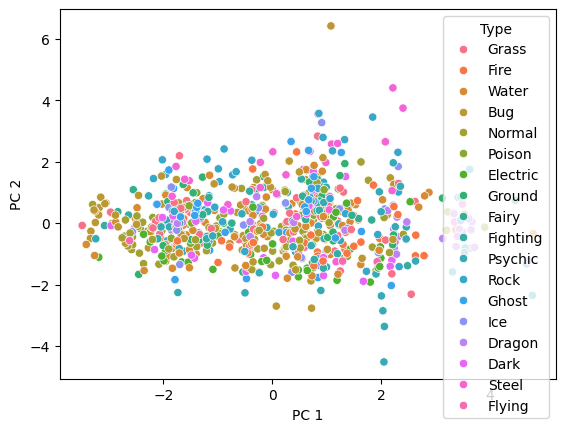

In [25]:
sns.scatterplot(data=poke_cat_df, x="PC 1", y="PC 2", hue="Type")

##### Instructions 4/4

* Use the Legendary feature to color the PC 1 versus PC 2 scatterplot.

<Axes: xlabel='PC 1', ylabel='PC 2'>

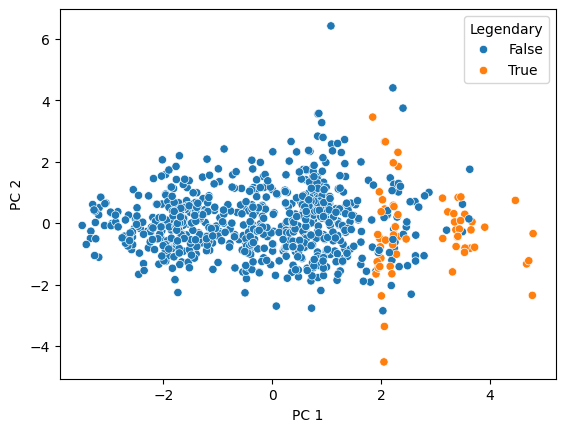

In [26]:
sns.scatterplot(data=poke_cat_df, x="PC 1", y="PC 2", hue="Legendary")

#### PCA in a model pipeline

We just saw that legendary Pokemon tend to have higher stats overall. Let's see if we can add a classifier to our pipeline that detects legendary versus non-legendary Pokemon based on the principal components.

The data has been pre-loaded for you and split into training and tests datasets: `X_train`, `X_test`, `y_train`, `y_test`.

Same goes for all relevant packages and classes(`Pipeline()`, `StandardScaler()`, `PCA()`, `RandomForestClassifier()`).

##### Instructions 1/4

* Add a scaler, PCA limited to 2 components, and random forest classifier with `random_state=0` to the pipeline.

In [27]:
# setup
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

y = poke_cat_df["Legendary"]
X = poke_df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [28]:
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("reducer", PCA(n_components=2)),
        ("classifier", RandomForestClassifier(random_state=0)),
    ]
)

##### Instructions 2/4

* Fit the pipeline to the training data.

In [29]:
pc = pipe.fit(X_train, y_train)

##### Instructions 3/4

* Score the model accuracy on the test set.

In [30]:
accuracy = pipe.score(X_test, y_test)

# Prints the model accuracy
print(f"{accuracy:.1%} test set accuracy")

92.1% test set accuracy


##### Instructions 4/4

* Repeat the process with 3 extracted components.

In [31]:
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("reducer", PCA(n_components=3)),
        ("classifier", RandomForestClassifier(random_state=0)),
    ]
)

pc = pipe.fit(X_train, y_train)
accuracy = pipe.score(X_test, y_test)

print(pipe["reducer"].explained_variance_ratio_)
print(f"{accuracy:.1%} test set accuracy")

[0.45673596 0.18599109 0.12852181]
93.8% test set accuracy


##  Principal Component selection

In the previous lesson we saw how you can set the number of components that the PCA algorithm should calculate. An alternative technique is telling PCA the minimal proportion of variance we want to keep and let the algorithm decide on the number of components it needs to achieve that. 

We can do this by passing a number between 0 and 1 to the n_components parameter of PCA. 

In [32]:
pipe = Pipeline([("scaler", StandardScaler()), ("reducer", PCA(n_components=0.9))])

pipe.fit(poke_df)

print(len(pipe["reducer"].components_))

5


When we pass it 0.9 it will make sure to select enough components to explain 90% of the variance. This turns out to be 5 for the Pokemon data.

One problem is that whether we set the number of components as an integer or a ratio, we're still just making these numbers up using gut feeling. Fact is, there is not a single right answer to the question "how many components should I keep?" since it depends on how much information you are willing to sacrifice to reduce complexity. 

### An optimal number of components

There is a trick that can help you find a good balance.

When you plot the explained variance ratio of a fitted PCA instance, you'll get to see that most of the explained variance is concentrated in the first few components.

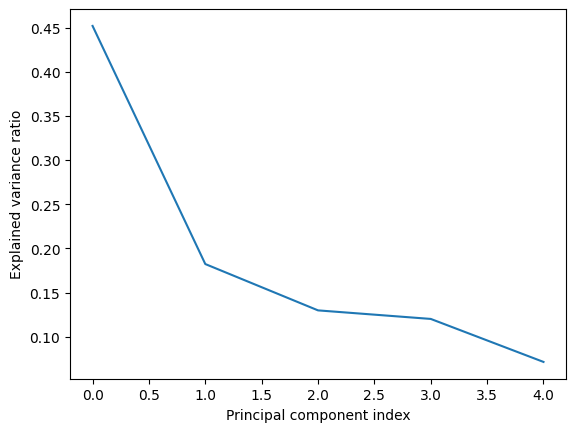

In [33]:
var = pipe["reducer"].explained_variance_ratio_

plt.plot(var)
plt.xlabel("Principal component index")
plt.ylabel("Explained variance ratio")
plt.show()

As you go from left to right in this type of plot you'll often see that the explained variance ratio per component starts to level out quite abruptly. The location where this shift happens is known as the 'elbow' in the plot. And it typically gives you a good starting point for the number of components to keep. Do note that the x-axis shows you the index of the components and not the total number. So since the elbow is at the component with index 1 here, we'd select 2 components. 

### PCA operations

Up until now, we've seen how you can use PCA to go from an input feature dataset `X` to a NumPy array of principal components `pc`, either by first fitting pca to the data and then transforming that data in two operations or in one go with the `.fit_transform()` method. A final trick that I'd like to teach you, is how to go back from the principal components to the original feature space. 

This can be done by calling the `.inverse_transform()` method on the principal component array. Because you typically lose information going from left to right in this overview, you'll see that the result from going back to the original feature space will have changed somewhat. 

### Compressing images

An application where this is relevant is image compression. Let's have a look at the "Labeled Faces in the Wild" dataset. The 15 images you see here are the test set. 

![alt text](images/labeled_faces.png)

It's a two dimensional NumPy array with 15 arrays of 2914 elements each. These elements correspond to the grayscale value of a pixel in the 62 by 47 pixel images. Our training set contains 1333 of such images. 

```python
print(X_test.shape)
```

```sh
(15, 2914)
```

62 X 47 pixels = 2914 grayscale values

```python
print(X_train.shape)
```

```sh
(1333m 2914)
```

We can build a pipeline where we tell PCA to select only 290 components and then fit this pipeline to our training data. If we then use this fitted model to transform the unseen test data, we'll get a 10 fold reduction in the number of features. We could now save our images with 10 times less disk space! 

```python
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reducer', PCA(n_components=290))
])
pipe.fit(X_train)
pc = pipe.fit_transform(X_test)

print(pc.shape)
```

```sh
(15, 290)
```

### Rebuilding images

Finally, we can perform the inverse transform operation to rebuild our pixels from the principal components. We then use a custom made `img_plotter()` function to create this output. 

```python
X_rebuilt = pipe.inverse_transform(pc)

print(X_rebuilt.shape)
```

```sh
(15, 2914)
```

```python
img_plotter(X_rebuilt)
```

![alt text](images/rebuilt_images.png)

While there is a loss of quality, the result is not bad.

#### Selecting the proportion of variance to keep

You'll let PCA determine the number of components to calculate based on an explained variance threshold that you decide.

You'll work on the numeric ANSUR female dataset pre-loaded as `ansur_df`.

All relevant packages and classes have been pre-loaded too (`Pipeline()`, `StandardScaler()`, `PCA()`).

##### Instructions 1/4

* Pipe a scaler to PCA selecting 80% of the variance.

In [37]:
# setup
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

ansur_df = pd.read_csv("data/ansur_II_female_numeric.csv")

ansur_df.shape

(1986, 94)

In [38]:
pipe = Pipeline([("scaler", StandardScaler()), ("reducer", PCA(n_components=0.8))])

##### Instructions 2/4

* Fit the pipe to the data.

In [40]:
pc = pipe.fit(ansur_df)

print(f'{len(pipe["reducer"].components_)} components selected')

11 components selected


##### Instructions 3/4

* Increase the proportion of variance to keep to 90%.

In [42]:
pipe = Pipeline([("scaler", StandardScaler()), ("reducer", PCA(n_components=0.9))])

pc = pipe.fit(ansur_df)

print(f'{len(pipe["reducer"].components_)} components selected')

23 components selected


##### Instructions 4/4

**Question**

How many additional features do you need to explain 90% instead of 80% of the variance?

**Possible answers**

1. 11
2. 12
3. 23

**Answer**

2. 12

#### Choosing the number of components

You'll now make a more informed decision on the number of principal components to reduce your data to using the "elbow in the plot" technique. One last time, you'll work on the numeric ANSUR female dataset pre-loaded as `ansur_df`.

All relevant packages and classes have been pre-loaded for you (`Pipeline()`, `StandardScaler()`, `PCA()`).

##### Instructions 1/4

* Create a pipeline with a scaler and PCA selecting 10 components.

In [10]:
# setup
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

ansur_df = pd.read_csv("data/ansur_II_female_numeric.csv")

In [7]:
pipe = Pipeline([("scaler", StandardScaler()), ("reducer", PCA(n_components=10))])

##### Instructions 2/4

* Fit the pipe to the data.

In [9]:
pc = pipe.fit(ansur_df)

##### Instructions 3/4

* Plot the explained variance ratio.

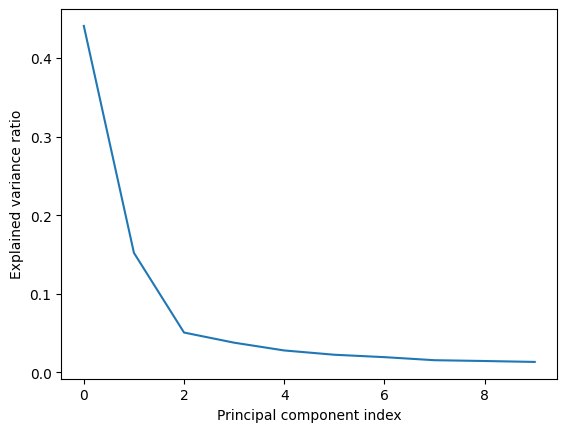

In [11]:
plt.plot(pipe["reducer"].explained_variance_ratio_)

plt.xlabel("Principal component index")
plt.ylabel("Explained variance ratio")
plt.show()

##### Instructions 4/4

**Question**

To how many components can you reduce the dataset without compromising too much on explained variance? Note that the x-axis is zero indexed.

**Possible answers**

1. 1
2. 2
3. 3
4. 4

**Answer**

3. 3

#### PCA for image compression

You'll reduce the size of 16 images with hand written digits (MNIST dataset) using PCA.

The samples are 28 by 28 pixel gray scale images that have been flattened to arrays with 784 elements each (28 x 28 = 784) and added to the 2D numpy array `X_test`. Each of the 784 pixels has a value between 0 and 255 and can be regarded as a feature.

A pipeline with a scaler and PCA model to select 78 components has been pre-loaded for you as `pipe`. This pipeline has already been fitted to the entire MNIST dataset except for the 16 samples in `X_test`.

Finally, a function `plot_digits` has been created for you that will plot 16 images in a grid.

#### Instructions 1/4

* Plot the MNIST sample data.


In [24]:
# setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

X_train = np.genfromtxt("data/mnist_train.csv", delimiter=",")
X_test = np.genfromtxt("data/mnist_test.csv", delimiter=",")

pipe = Pipeline([("scaler", StandardScaler()), ("reducer", PCA(n_components=78))])

pc = pipe.fit(X_train)


def plot_digits(data):
    fig, axes = plt.subplots(
        nrows=4,
        ncols=4,
        figsize=(6, 6),
        subplot_kw={"xticks": [], "yticks": []},
        gridspec_kw=dict(hspace=0.05, wspace=0.05),
    )
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(28, 28), cmap="binary", clim=(0, 300))
    plt.show()

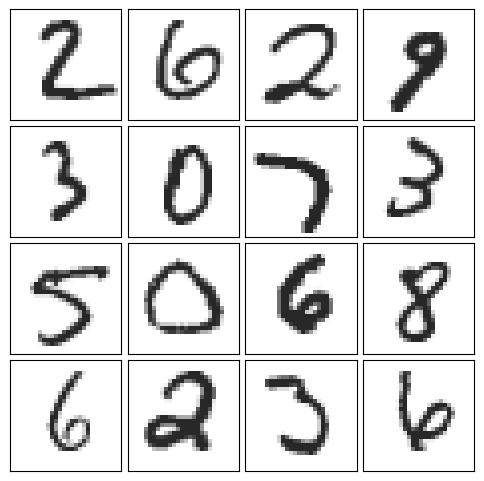

In [25]:
plot_digits(X_test)

#### Instructions 2/4

* Transform the input data to principal components using the pipeline.

In [26]:
pc = pipe.transform(X_test)

# print the number of features per dataset
print(f"X_test has {X_test.shape[1]} features")
print(f"pc has {pc.shape[1]} features")

X_test has 784 features
pc has 78 features


#### Instructions 3/4

* Inverse transform the components back to the original feature space.

In [27]:
X_rebuilt = pipe.inverse_transform(pc)

# Prints the number of features
print(f"X_rebuilt has {X_rebuilt.shape[1]} features")

X_rebuilt has 784 features


#### Instructions 4/4

* Plot the reconstructed data.

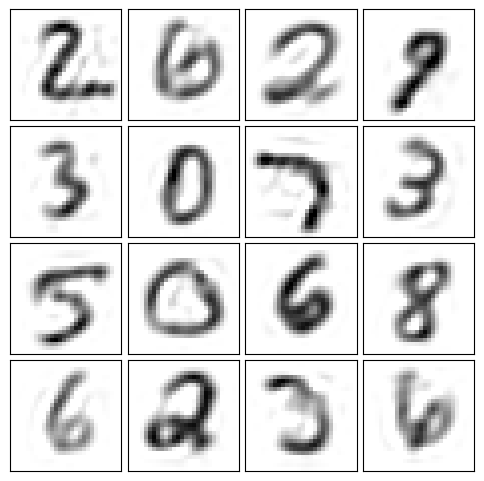

In [28]:
plot_digits(X_rebuilt)

`mnist_train.csv` was too large to upload to GitHub so I zipped both files in the dataset.